# Recommendation Systems in Media Publishing
Project Developer & Writer: Kevin Jang

### Background
The Other People Magazine website hosts hundreds of posts and artworks with a search bar to filter out posts that a user is looking for. When the user has not made a query but focuses on the search bar, a set of the most recent ten posts published are displayed. 

*What if the user enjoyed reading a literary piece and wanted similar stories?*

*What if the user wanted to see similar artworks?*

*What if the user wanted to find other posts with similar tags or even languages?*

**Product recommendation systems** attempt to resolve these user cases by recommending similar works to the current work. These systems also act as filters by predicting the next product to recommend based on the inputs fed through the system. These systems work by taking in a set of inputs, extracting features from each input, defining a similarity function, and finally taking the K nearest neighbors.

Other People Magazine's use case differs by the *products* that it is able to recommend. We are dealing with **literature** and **art**, two highly subjected fields with which to predict the user's expectations. Our organization has a limitation in which we are unable to build recommendations between users or store the state of page breadcrumbs that the user created. This limitation comes from the fact that the website is client-based and not hosted on its own server where this could be accomplished through the use of cookies. Despite these limitations, we can still recommend creative works using **content-based recommendation systems**. This Notebook will go through the different kinds of models and test their predictions to determine the best approach to recommending subjectivity.

## Metadata Count Feature Recommender
This recommendation model is meant to extract features from the metadata in each post and determine similarity between them. Of the metadata features, four influence the recommendation the most: `tags`, `contributor`, `wordCount`, and `title`. The tags would be a good recommendation for readers who are interested in works of the same genre. The contributors, also known as the writers and/or artists, could interest the reader and thus recommend similar works by the authors. Word count can also play a role in determining if the reader wants to enjoy works of a similar length. In specific cases, the title could have an influence on the prediction. For example, "Mother Moon", a visual artwork should recommend "Mother Moon (interview)" and vice versa because they have high relevance to each other.

This model will use a count vector of the terms that show up in the metadata as a simple demonstration of how the recommender systems work. It is not expected to be a highly accurate model and the reasons will be explained at the end of this section.

In [1]:
import requests
import json
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

To access the creative works at Other People, we can utilize the API built in the frontend to extract particular information from each post.

In [2]:
res = requests.get('https://www.otherpeoplesd.com/api/post-data.json')
data = json.loads(res.text)
postSlugs = data.keys()
# Convert the json data to a list for indexing
listRes = [k for k,v in data.items()]

In [3]:
# Converts array metadata by converting each element into a single word
# Removes additional styling details in how contributor or tag fields were written
def reformatArray(arr, key):
    try:
        if key == 'contributor':
            arr = re.split(',|&', arr)
            
        reformatted = []
        for item in arr:
            if key == 'contributor':
                item = re.sub(r'\(.*\)', '', item)
                
            item = item.strip()
            words = item.split(' ')
            
            if key == 'tags' and len(words) > 1:
                for w in words:
                    reformatted.append(w)
                    
            item = ''.join(words)
            reformatted.append(item)
        return reformatted
    except:
        return arr

In [4]:
metaFeats = []
for post in postSlugs:
    postData = data[post]
        
    postData['contributor'] = reformatArray(postData['contributor'], 'contributor')
    postData['tags'] = reformatArray(postData['tags'], 'tags')
    
    # Force edit word count to the manually set word count on custom-built works
    if 'manualWC' in postData:
        postData['wordCount'] = postData['manualWC']
        del postData['manualWC']
    
    feat = ''.join(postData['title']) + ' ' + ' '.join(postData['contributor']) + ' ' + ' '.join(postData['tags']) + ' ' + str(postData['wordCount'])
    feat = feat.lower()
    metaFeats.append(feat)

In [5]:
# Example of reformatted metadata features
metaFeats[0]

'nesting dolls and snakeskin ivydu fiction 2926'

After formatting the metadata for each post, features must be extracted out of them in a way that they can be compared against each other properly. This is done by taking a count vector to determine how often terms appear in the features. 

In [6]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metaFeats)
print(count_matrix.shape)

(148, 532)


Now that the features have been extracted, we must define a similarity function. 

The two most common similarity functions for recommendation systems are **Euclidean distance** and **cosine similarity**. Euclidean distance measures the distance between two points while cosine similarity measures the angle between the two points. Euclidean distance is affected by magnitude, so it isn't a great option when taking a frequency count for the extracted features. The angle would be better because it won't be affected too much by magnitude changes.

$$\text{Euclidean Distance}$$
$$\quad d(p,q) = \sqrt{\sum^n_{i=1}(p_i-q_i)^2}$$

$$\text{Cosine Similarity}$$
$$cos(\theta) = \frac{A \cdot B}{||A|| \cdot ||B||} = \frac{\sum^n_{i=1}A_i \cdot B_i}{\sqrt{\sum^n_{i=1}A_i^2 \cdot \sum^n_{i=1}B_i^2}}$$

In [7]:
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim_count.shape)

(148, 148)


In [8]:
# Recommendation model with k closest works (K closest neighbors algorithm)
def recommender_system(slug, cosine_sim,
                       k=10, showSim=False, sigFigs=4):
    idx = listRes.index(slug)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]
    if showSim:
        sim_slugs = [(listRes[item[0]], round(item[1], sigFigs)) for item in sim_scores] 
    else:
        sim_slugs = [listRes[item[0]] for item in sim_scores]
    return sim_slugs

In [9]:
rec_metadata = recommender_system('/3/blame-and-balm', cosine_sim_count,
                             k=10, showSim=True, sigFigs=4)
rec_metadata

[('/3/blame-and-balm-interview', 0.4629),
 ('/2023/out-of-use', 0.2041),
 ('/2023/planet', 0.2041),
 ('/2023/too-easily', 0.2041),
 ('/4/kalbelia', 0.2041),
 ('/2022/dictionary', 0.2041),
 ('/2022/routines', 0.2041),
 ('/2021/butterflies', 0.2041),
 ('/2021/puppydom', 0.2041),
 ('/1/2230', 0.2041)]

In [10]:
rec_metadata = recommender_system('/1/untitled', cosine_sim_count,
                             k=10, showSim=True, sigFigs=4)
rec_metadata

[('/2/underdog', 0.6),
 ('/2/now-playing', 0.6),
 ('/1/fronteras', 0.6),
 ('/1/monotony', 0.6),
 ('/1/skin-esbensen', 0.6),
 ('/1/dissonance', 0.6),
 ('/4/in-a-haze', 0.5477),
 ('/4/teacup', 0.5477),
 ('/4/highway', 0.5477),
 ('/3/abiding-vestige', 0.5477)]

As seen in both of these results, many recommendations have the same similarity score for both prose and visual arts pages. This is an issue because the low dimensionality aided by many works with the same tags makes it harder to tell if the recommended work is truly appropriate. Also, the posts in the API are sorted in chronological order according to when they were posted, so the most recent works are recommended first. This disadvantages older posts from being visible in the recommendation. We can check how much loss occurs by looking at the connected components made in the recommendation graph and seeing what posts barely get recommended.

In [11]:
metaRecs = {}
for slug in listRes:
    rec_metadata = recommender_system(slug, cosine_sim_count,
                                         k=10, showSim=False)
    metaRecs[slug] = rec_metadata

In [12]:
# Print connected components in the recommendation graph 
# to check the diversity of recommendation

def test_rec_diversity(recommendations, showConnections=False):
    def dfs(u): 
        if u in seenSet:
            return
        seenSet.add(u)
        for v in recommendations[u]:
            dfs(v)
    # Find direct recommendations
    countDirects = {}
    for post in postSlugs:
        seenSet = set()
        dfs(post)
        if showConnections:
            print(len(seenSet), post)
        countDirects[post] = 0
        for direct in recommendations[post]:
            countDirects[direct] = countDirects.get(direct, 0) + 1
    sortedDirect = sorted(countDirects.items(), key=lambda i: i[1])
    return sortedDirect

In [13]:
meta_direct_recs = test_rec_diversity(metaRecs, showConnections=False)
meta_direct_counts = {}
for k,v in meta_direct_recs:
    meta_direct_counts[v] = meta_direct_counts.get(v, 0) + 1
print('(k, num) posts with direct recommendations:', meta_direct_counts)
# sortedDirect

(k, num) posts with direct recommendations: {0: 50, 1: 22, 2: 22, 3: 13, 4: 3, 5: 7, 6: 2, 7: 4, 8: 1, 10: 1, 11: 2, 12: 1, 15: 2, 16: 1, 17: 2, 18: 2, 19: 2, 20: 1, 21: 1, 22: 1, 31: 1, 32: 1, 38: 1, 40: 1, 45: 1, 47: 1, 50: 1, 52: 1}


There are fifty posts that do not get recommended by any other post. This is a significant issue because a third of all webpages do not get recommended at all! Even worse, two-thirds of all webpages get recommended at most two times. This is a bad recommendation model that requires more input information to make more diverse recommendations.

In [14]:
# Convert the result to JSON and write to file
with open('recommender-meta.json', mode='w', encoding='utf8') as outfile:
    outfile.write(json.dumps(metaRecs))

## Content-Only TF-IDF Recommender
This model makes recommendations based on the content of works through the `noHTML` key. Because there will be many different words from the content and styles of writers, the corpus accumulated by taking a simple count vector will make many frequencies zero in the similarity matrix. There is also an issue of semantic context that the count vector will not address. To address these issue, we will be using TF-IDF to extract and vectorize the features so that certain terms will be weighed higher than others. 

*Term frequency* (TF) is used to measure the frequency that a term has occurred in the data. *Inverse document frequency* (IDF) measures how important a term is in the data by checking its rarity across all works. These two factors are compared in cosine similarity to recommend works that have similar important keywords or topics to match what a reader may like to consume next.

$$tf(t,d) = \frac{\text{frequency}}{\text{frequency of most common word}}$$
$$idf(t,D) = -log P(t|D) = log \frac{N}{|\{d \in D: t \in d\}|}$$

$$tfidf(t,d,D) = tf(t,d) \times idf(t,D)$$

While TF-IDF would work on only metadata, it would not have been a strong model because of a small corpus to make recommendations on. That is why a simple, lightweight count sufficed for checking similarity before taking the cosine.

In [15]:
# Do NOT add alt text to the content!
# The alt text was not written by the author or artist.
# Image similarity resolves this by examining the features.
onlyContent = []
for slug in postSlugs:
    post = data[slug]
    altIdx = post['noHTML'].find('img_alt:')
    if altIdx != -1:
        onlyContent.append(post['noHTML'][:altIdx])
        # img_alt = post['noHTML'][altIdx:]
        # img_alt = re.sub('img_alt: ', '', img_alt)
        # newList = []
        # for w in img_alt.split(' '):
        #     newList += ['img_alt_' + w]
        # onlyContent.append(post['noHTML'][:altIdx] + ' '.join(newList))
    else:
        onlyContent.append(post['noHTML'])

To address semantic context inside the posts, we can choose the n-grams parameter to pass into the TF-IDF vector. N-grams means the number of adjacent words that form a term in the corpus. Bigrams provides more accurate recommendations in this model because viewing adjacent words can identify positive or negative connotations happening in the story. 

This model uses both unigrams and bigrams for the feature vector. This was found to have the most accurate predictions.

In [16]:
ngram_range = (1,2)
tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
tfidf_matrix = tfidf.fit_transform(onlyContent)

In [17]:
tfidf_matrix.shape

(148, 54400)

In [18]:
cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_tfidf.shape

(148, 148)

In [19]:
rec_tfidf = recommender_system('/3/blame-and-balm', cosine_sim_tfidf,
                             k=10, showSim=True, sigFigs=4) 
rec_tfidf

[('/2023/stillwater-saint', 0.0428),
 ('/2023/nesting-dolls-and-snakeskin', 0.0318),
 ('/3/high-tide', 0.0286),
 ('/2/fishbowl-brain', 0.0286),
 ('/2023/dear-guma', 0.0272),
 ('/3/the-middle-of-all-middles', 0.0255),
 ('/2023/the-greatest-author', 0.0254),
 ('/3/sing', 0.0249),
 ('/2022/validation', 0.0241),
 ('/2021/requiem', 0.024)]

In [20]:
rec_tfidf = recommender_system('/5/ascension', cosine_sim_tfidf,
                             k=10, showSim=True, sigFigs=4) 
rec_tfidf

[('/2023/hole', 0.0),
 ('/2023/out-of-use', 0.0),
 ('/2023/planet', 0.0),
 ('/2023/outdated', 0.0),
 ('/2023/the-greatest-author', 0.0),
 ('/2023/too-easily', 0.0),
 ('/6/you-have-created-an-imaginary-friend', 0.0),
 ('/6/editors-note', 0.0),
 ('/2023/stillwater-saint', 0.0),
 ('/2023/i-keep-driving-east', 0.0)]

There is much more variation in recommendations with this content model, although we lose the strong recommendation of the interview piece that should be paired with "Blame and Balm". If the metadata-based and content-based recommenders were combined, the recommendation could become stronger.

Note that if we attempt to view recommendation for visual art pieces, the similarities are all zero. These pages have no content&mdash;no words to extract features for. This leaves visual arts pieces worse off than the simple metadata recommender.

In [21]:
tfidfRecs = {}
for slug in listRes:
    rec_tfidf = recommender_system(slug, cosine_sim_tfidf,
                                   k=10, showSim=False)
    tfidfRecs[slug] = rec_tfidf

In [22]:
tfidf_direct_recs = test_rec_diversity(tfidfRecs, showConnections=False)
tfidf_direct_counts = {}
for k,v in tfidf_direct_recs:
    tfidf_direct_counts[v] = tfidf_direct_counts.get(v, 0) + 1
print('(k, num) posts with direct recommendations:', tfidf_direct_counts)
tfidf_direct_recs[-10:]

(k, num) posts with direct recommendations: {0: 65, 1: 27, 2: 9, 3: 9, 4: 4, 5: 4, 6: 2, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 16: 1, 18: 1, 20: 1, 23: 3, 26: 1, 30: 1, 31: 1, 32: 1, 33: 2, 35: 1, 36: 1, 39: 2, 45: 2, 46: 1, 55: 1, 60: 1, 67: 1}


[('/2023/the-greatest-author', 35),
 ('/6/editors-note', 36),
 ('/2023/hole', 39),
 ('/2023/always-the-victim', 39),
 ('/2023/nesting-dolls-and-snakeskin', 45),
 ('/4/mirror-shards', 45),
 ('/5/lament-for-the-old-man', 46),
 ('/2023/stillwater-saint', 55),
 ('/2023/outdated', 60),
 ('/2023/homewrecker', 67)]

Around two thirds of all posts have no more than one recommend post. However, we can see the relationship between the recommendations with zero similarity by comparing the posts recommended in chronological order to the posts that have the most direct recommendations. "Hole", "Outdated", "Always the Victim" are all in the top ten.

In [23]:
# Convert the result to JSON and write to file
with open('recommender-content.json', mode='w', encoding='utf8') as outfile:
    outfile.write(json.dumps(tfidfRecs))

## Meta + Content TF-IDF Recommender

This model combines the metadata feature from the metadata and the content string into a single feature string. TF-IDF is used to build the recommendations. To make the metadata have higher signifcance than the content of the posts and to prevent terms from being counted with the content of the post, each metadata feature should be labeled separately. We will attach a string prefix to each of the formatted metadata features 

In [24]:
# Tag the strings in metadata to be distinct from the textual content
for i, meta in enumerate(metaFeats):
    newList = []
    for j, w in enumerate(meta.split(' ')):
        newList += ['meta_' + w]
    metaFeats[i] = ' '.join(newList)

In [25]:
meta_content_feat = np.array([l1 + ' ' + l2 for l1, l2 in zip(metaFeats, onlyContent)])

In [26]:
ngram_range = (1,3)
tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
meta_tfidf_matrix = tfidf.fit_transform(meta_content_feat)
print(meta_tfidf_matrix.shape)

(148, 103094)


In [27]:
cosine_sim_meta_tfidf = cosine_similarity(meta_tfidf_matrix, meta_tfidf_matrix)
print(cosine_sim_meta_tfidf.shape)

(148, 148)


In [28]:
rec_tfidf = recommender_system('/3/blame-and-balm', cosine_sim_meta_tfidf,
                               k=10, showSim=True, sigFigs=4)
rec_tfidf

[('/2023/stillwater-saint', 0.0286),
 ('/2023/nesting-dolls-and-snakeskin', 0.0207),
 ('/3/blame-and-balm-interview', 0.0195),
 ('/2/fishbowl-brain', 0.0189),
 ('/3/high-tide', 0.0179),
 ('/2023/the-greatest-author', 0.0172),
 ('/3/the-middle-of-all-middles', 0.0169),
 ('/2023/dear-guma', 0.0166),
 ('/3/sing', 0.0163),
 ('/2020/hope-came-last', 0.0146)]

This result shows that the interview is included in the recommendations! However, the interview is not the top result. This could mean several things such as the content in "Stillwater Saint" is a better match wheras the interview is less relevant to the actual "Blame and Balm" story.

In [29]:
meta_tfidf_Recs = {}
for slug in listRes:
    rec_meta_tfidf = recommender_system(slug, cosine_sim_meta_tfidf,
                                         k=10, showSim=False)
    meta_tfidf_Recs[slug] = rec_meta_tfidf

In [30]:
meta_tfidf_direct_recs = test_rec_diversity(meta_tfidf_Recs, showConnections=False)
meta_tfidf_direct_counts = {}
for k,v in meta_tfidf_direct_recs:
    meta_tfidf_direct_counts[v] = meta_tfidf_direct_counts.get(v, 0) + 1
print('(k, num) posts with direct recommendations:', meta_tfidf_direct_counts)
meta_tfidf_direct_recs[-10:]

(k, num) posts with direct recommendations: {0: 44, 1: 32, 2: 14, 3: 15, 4: 8, 5: 3, 6: 4, 7: 2, 8: 2, 9: 1, 10: 4, 11: 3, 12: 1, 16: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 3, 27: 1, 34: 1, 37: 1, 39: 1, 42: 1, 49: 1, 65: 1}


[('/2023/dear-guma', 22),
 ('/3/sing', 22),
 ('/4/worm', 22),
 ('/2023/stillwater-saint', 27),
 ('/2023/always-the-victim', 34),
 ('/2023/outdated', 37),
 ('/2023/nesting-dolls-and-snakeskin', 39),
 ('/4/mirror-shards', 42),
 ('/5/lament-for-the-old-man', 49),
 ('/2023/homewrecker', 65)]

Less than a third of all posts do not have a recommendation, but now two thirds of all posts have at most four recommendations. This model has taken the shortcomings of the metadata and content-only models to diversify the result more and also have more accurate predictions between posts relevant to each other!

In [31]:
# Convert the result to JSON and write to file
with open('recommender-both.json', mode='w', encoding='utf8') as outfile:
    outfile.write(json.dumps(meta_tfidf_Recs))

It is too early to conclude this as a successful model when we still have a major persistent issue. Let's look at an example of a work that is not text-based, e.g. an artwork.

In [32]:
recommender_system('/1/treasure', cosine_sim_meta_tfidf, 
                k=10, showSim=True, sigFigs=6)

[('/1/skin-vilar', 0.03301),
 ('/1/skin-esbensen', 0.031624),
 ('/1/dissonance', 0.031321),
 ('/1/fronteras', 0.03074),
 ('/2/underdog', 0.030462),
 ('/1/untitled', 0.030462),
 ('/1/monotony', 0.030462),
 ('/4/teacup', 0.027562),
 ('/4/highway', 0.027562),
 ('/2/life-cycle', 0.027006)]

There are several works that still have the same similarity values. The reason the recommendations are nonzero is because of the metadata features that are similar to the artwork while the TF-IDF content part would still remain as zero. We can do better with our literary arts recommendation system by now turning our focus to visual similarity recommendation models.

## Artwork Visual Similarity Recommendation

While literature can be modeled through content-based recommendation systems, art must take a different approach. This is because 1. images are a matrix of pixels ranging from 0 to 255 and 2. art is subjective, thus the recommendations may not match the user's preference without much needed user input. Without tracking breadcrumbs to figure out what the user's interests are, we can instead build a recommendation system independent of user input via visual similarity modeling.

This recommendation system uses deep learning to perform image recommendation because of how image data must be converted into features for comparison. There are many different ways to compare image data, but we will be using the convolutional neural network (CNN) VGG16 model with transfer learning for image recommendation. VGG16 is commonly used in image classification and it can be pretrained with a huge set of images to figure out how to classify these images based on many convolution and pooling layers. Because the model is being trained on imagenet, a database of over a million images, to best-fit its hyperparameters, we can input our own small set of data to make accurate predictions using its hyperparameters through the concept of transfer learning.

However, the concepts of image classification and image similarity differ and this influences how VGG16 is used in the system. Image classification attempts to group images into clusters or groups to make recommendations, but it entraps the inputs because it can only classify based on the kinds of labels the input can be. Image similarity does not use labels to fix an input into a defined category and instead uses the difference between features in the images to determine the output. To make VGG16 work for image similarity, the output layer must be changed such that it extracts features instead of outputting predictions based on the data labels.

To find the difference between images, we use cosine similarity over the features in each image. The CNN finds the best representation for the images and thus these features represent how the image is compared to others. As such, the angle between images would be a more accurate determiner of similarity rather than taking the euclidean distances. For example, two identical images may have changed only by their BRG/RBG color magnitude and thus they may have a high distance between each other, but their angle should be around the same because of the color edges and textures in the image. After creating the cosine similarity matrix, we can repurpose the same recommendation algorithm used in the content-based recommendation system to get our recommendations through K closest neighbors.

Using the cosine also gives the benefit of combining the visual features to the text content features such that recommendations on the works with both literature and art can lead to recommendations that branch into both literature and visual arts. This is a significant benefit because the artworks found in a work of literature could help recommend posts with the same atmosphere based on similar images. Visual arts pages will also find themselves in places of more engagement as they are being recommended on works of literature. 

To improve this recommender system, try using different models such as ResNet, VGG, AlexNet, or even custom CNNs trained on a large image set.

### Loading and Formatting Image Data

Exposing artwork onto an API without proper authentication is not secure because adversaries could circumvent levels of copy-prevention by querying the API to copy the works. Therefore, the works should be downloaded to the machine so that they can be directly accessed through the local filesystem.

In [33]:
import requests
import json
from tqdm.notebook import tnrange, tqdm
# import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import walk
import cv2

In [34]:
# Get all posts regardless if they contain images
# This endpoint runs a little faster than the post-data endpoint and we only need to get the postSlugs 
res = requests.get('https://www.otherpeoplesd.com/api/post-metadata.json')
data = json.loads(res.text)
postSlugs = data.keys()
# Convert the json data to a list for indexing
listRes = [k for k,v in data.items()]

In [35]:
# Assuming the notebook is in the documentation repo (./Docs/) and the images are in the Calla-Lily repo
imgDir = '../Calla-Lily/public/images/'
imgPaths = []
for (dirpath, _, filenames) in walk(imgDir):
    filePath = [dirpath.replace('\\', '/') + '/' + filename for filename in filenames]
    imgPaths.extend(filePath)
imgPaths[:5]

# Display the images and their indices
# for i,p in enumerate(imgPaths):
#     print(i,p)

['../Calla-Lily/public/images/1/amsterdam-nightlife-1-marcin-kierebinski.jpg',
 '../Calla-Lily/public/images/1/amsterdam-nightlife-2-marcin-kierebinski.jpg',
 '../Calla-Lily/public/images/1/boys-night-1-jack-yang.png',
 '../Calla-Lily/public/images/1/boys-night-2-jack-yang.png',
 '../Calla-Lily/public/images/1/brain-fish-zhilin-li.png']

In [36]:
postImgs = {}

for slug in tqdm(postSlugs, desc='assigning images to posts', position=0, leave=True):
    postRes = requests.get('https://www.otherpeoplesd.com/api/post' + slug)
    postData = json.loads(postRes.text)
    postImgs[slug] = []
    for fullPath in imgPaths:
        path = fullPath.replace(imgDir, '')
        if path in postData['contentHtml']:
            postImgs[slug].append(fullPath)

assigning images to posts: 100%|██████████| 148/148 [00:45<00:00,  3.29it/s]


In [37]:
def getPostFromImg(slug):
    for k,imgPathArr in postImgs.items():
        if slug in imgPathArr:
            return k

getPostFromImg(imgDir + '1/amsterdam-nightlife-1-marcin-kierebinski.jpg')    

'/1/i-left-my-heart-in-amsterdam'

In [38]:
def printImg(imgPath):
    BGRimg = cv2.imread(imgPath)
    img = cv2.cvtColor(BGRimg, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

### Using the pretrained VGG16 on imagenet
Tensorflow has several `preprocess_input` methods depending on the prebuilt model being used. We have found that using the imagenet `preprocess_input` has better accuracy than VGG16's `preprocess_input`. This could be because the inputs to the VGG16 model is imagenet data and thus it makes sense to transform our own image inputs to match imagenet. 

In [39]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array 
from sklearn.metrics.pairwise import cosine_similarity

While the Keras documentation has examples of how to extract features instead of using the model for image classification (https://keras.io/api/applications/#usage-examples-for-image-classification-models), the prediction function throws errors at the input.

Changing the output layer to be the one before the prediction layer results in features extracted to a vector of size 4096.

In [40]:
model_vgg16 = VGG16(weights='imagenet', include_top=True)
feature_extraction = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer("fc2").output)

In [41]:
feature_extraction.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
def readData_tf(imgPaths, target_size):
    imgSlugs = []
    imgData = []
    for path in tqdm(imgPaths, desc='reading img data'):
        # print(path)
        if '.gif' in path:
            continue
        img = load_img(path, target_size=target_size, keep_aspect_ratio=True)
        img = img_to_array(img)
        # print(img.shape)
        imgSlugs.append(path)
        imgData.append(img)
    return imgSlugs, imgData

In [43]:
# target_size = minDim
target_size = (224,224)
tf_imgSlugs, tf_imgData = readData_tf(imgPaths, target_size=target_size)

reading img data:  36%|███▌      | 47/132 [00:03<00:04, 20.45it/s]C:\Users\Kevin\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (99000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
reading img data: 100%|██████████| 132/132 [00:09<00:00, 13.48it/s]


In [44]:
tf_imgData = np.array(tf_imgData)
print(tf_imgData.shape)
tf_imgData = preprocess_input(tf_imgData)
features_tf = feature_extraction.predict(tf_imgData)
print(features_tf.shape)

(130, 224, 224, 3)
5/5 [==============================] - 12s 2s/step
(130, 4096)


In [45]:
cosine_sim_tf = cosine_similarity(features_tf)
cosine_sim_tf.shape

(130, 130)

In [46]:
cosine_sim_tf

array([[1.0000001 , 0.5031772 , 0.23751105, ..., 0.1317079 , 0.28118014,
        0.21835047],
       [0.5031772 , 1.0000001 , 0.21519426, ..., 0.16504104, 0.28393784,
        0.23923588],
       [0.23751105, 0.21519426, 1.0000001 , ..., 0.19529504, 0.3781404 ,
        0.24039938],
       ...,
       [0.1317079 , 0.16504104, 0.19529504, ..., 0.9999998 , 0.26677018,
        0.24800706],
       [0.28118014, 0.28393784, 0.3781404 , ..., 0.26677018, 0.9999998 ,
        0.3685978 ],
       [0.21835047, 0.23923588, 0.24039938, ..., 0.24800706, 0.3685978 ,
        1.0000002 ]], dtype=float32)

### Define the Recommendation System

In [47]:
# Retrieve the K closest images
def getKClosest(slug, k, showSim, sigFigs, sim_scores, parent_post, corrected=True):
    res = []
    i = 0
    for item in sim_scores:
        if '.gif' in imgPaths[item[0]]:
            continue
        if corrected and i < k:
            if imgPaths[item[0]] in postImgs[parent_post]:
                continue
        if i == k:
            return res
        if showSim:
            res.append((imgPaths[item[0]], round(item[1], sigFigs)))
        else:
            res.append(imgPaths[item[0]])
        i += 1
    return res

In [48]:
# Recommendation model with k closest works
def vgg16Recommender(slug, cosine_sim, k=10, showSim=False, sigFigs=4):
    idx = imgPaths.index(slug)
    parent_post = getPostFromImg(slug)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    i = 0

    corrected_sim_slugs = getKClosest(slug,k,showSim,sigFigs,
                                      sim_scores,parent_post)
    
    uncorrected_sim_slugs = getKClosest(slug,k,showSim,sigFigs,
                                        sim_scores,parent_post,corrected=False)
    
    return corrected_sim_slugs, uncorrected_sim_slugs

In [49]:
def displayRecs(inputImg, cosine_sim, corrected=True):
    k = 10
    recommend, uncorrected = vgg16Recommender(inputImg, cosine_sim=cosine_sim, 
                                              k=k, showSim=True, sigFigs=4)
    print('original img')
    printImg(inputImg)
    
    print('recommendations',('(corrected)' if corrected else '(uncorrected)'))
    for i in range(k):
        plt.subplot(5,2, i+1)
        BGRimg = None            
        if corrected:
            BGRimg = cv2.imread(recommend[i][0])
        else:
            BGRimg = cv2.imread(uncorrected[i][0])
        img = cv2.cvtColor(BGRimg, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        
    plt.show()

The recommender has two outputs, an array of corrected results and an array of uncorrected results. Both outputs are important for analyzing the accuracy of the CNN model's feature extraction.

The corrected results removes images from the recommendation if they are found on the same website page. This corrected output is meant to recommend other artworks that reside on other pages to encourage the user to branch out to those pages.  

The following is an example of what this recommendation looks like.

In [50]:
recommend, uncorrected = vgg16Recommender(imgPaths[123], cosine_sim_tf,
                                          k=10, showSim=True, sigFigs=4)
recommend

[('../Calla-Lily/public/images/5/yours-truly-you-2-allison-gable.png', 0.7143),
 ('../Calla-Lily/public/images/3/MoAM-kristy-lee-2.png', 0.7014),
 ('../Calla-Lily/public/images/2/may-flowers-2.png', 0.6026),
 ('../Calla-Lily/public/images/2023/to-build-castles-in-the-sky-spencer-vossman.webp',
  0.5906),
 ('../Calla-Lily/public/images/2020/easy-tea-for-sore-throat.png', 0.5094),
 ('../Calla-Lily/public/images/5/porcelain-in-silks-guyon-perez.jpg', 0.4852),
 ('../Calla-Lily/public/images/4/dahlias-kristy-lee.jpg', 0.4719),
 ('../Calla-Lily/public/images/2020/in-honor-of-parasite-hemmy-chun.jpg',
  0.4529),
 ('../Calla-Lily/public/images/2022/west-coast-elegies-amy-stukenholtz.jpg',
  0.4491),
 ('../Calla-Lily/public/images/1/golden-boy-kelly-tran.png', 0.4449)]

These similarity scores are fairly high when we consider that this is meant to model similarity over artworks that should not be remotely similar to each other. We can check the images to see how these numbers reflect what is shown.

original img


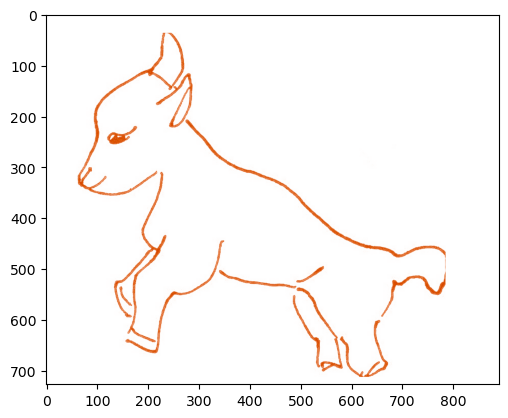

recommendations (corrected)


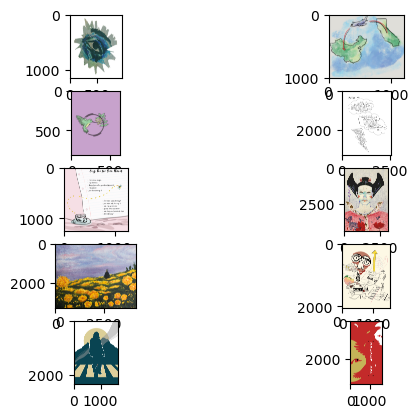

In [51]:
displayRecs(imgPaths[123], cosine_sim_tf)

There is good variation between the images recommended. We can see that this line art illustration does recommend illustrations with sharp lines or high contrast edges. This is expected behavior as there are no other line art illustrations except for the ones found on the same page.

The corrected result is what will be served as the final output to the frontend application. On the other hand, the uncorrected result is the recommendation based on all images in the artwork dataset. This means that an image in one website page could be recommended to a different image in the same webpage. This is good information for determining if the model is making accurate predictions by seeing if illustrations created by the same artist will recommend themselves for the same creative context. 

For example, we could test the model's outputs over the story "The Twelve Zodiac Animals". Helen Huang created many illustrations that have similar styles and thus they should result in a high similarity score compared to other illustrations in other stories or works.

original img


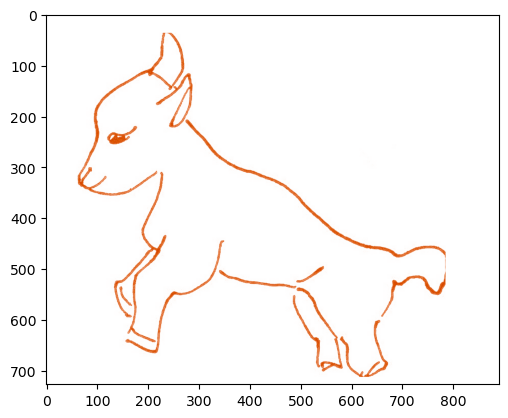

recommendations (uncorrected)


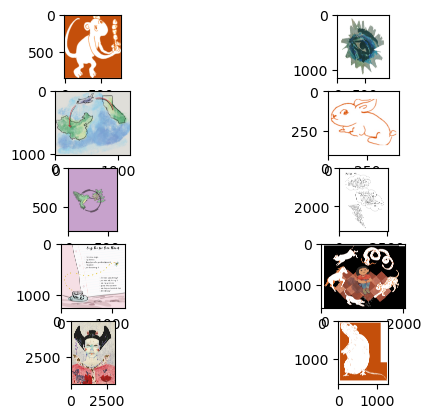

In [52]:
displayRecs(imgPaths[123], cosine_sim_tf, corrected=False)

### Fit the Image Recommender to Predict Posts

The visual similarity model now works as expected to recommend other artworks. Now we would like to use this recommender to predict different pages with respect to the image similarities. To do this we need to make the image similarity's cosine matrix match the same shape as the number of posts. We can reformat our CNN's feature predictions by the webpage instead of by the image.

For pages without images, there won't be any features and thus the weights will all be zero. 

One particular issue is how to combine the features in a page that has more than one artwork. We could take the mean vector to come up with an angle in the center of the image differences. This is the better approach than taking the max/min because that will cause the same problems that Euclidean distances has. The average angle would represent how the post's image styles are represented together. And usually the posts with complementary illustrations are not too different from each other.


In [53]:
clusterFeatsByPost = []
tf_imgFeats = [(s,f) for s,f in zip(tf_imgSlugs, features_tf)]

for slug in postSlugs:
    postFeats = []
    imagesInPost = postImgs[slug]

    # Posts without images
    if len(imagesInPost) == 0:
        postFeats = [0] * features_tf.shape[1]
        clusterFeatsByPost.append(postFeats)
        continue
        
    # Get the array of images in a post
    for s, feat in tf_imgFeats:
        if s in imagesInPost:
            postFeats.append(feat)
            
    # Again, posts without images (because of GIFs)
    if len(postFeats) == 0:
        postFeats = [0] * features_tf.shape[1]
        clusterFeatsByPost.append(postFeats)
        continue

    # Combine the features together
    postFeats = np.mean(np.array(postFeats), axis=0)
    clusterFeatsByPost.append(postFeats)

In [54]:
# Expect: (# of posts, CNN output size)
clusterFeatsByPost = np.array(clusterFeatsByPost)
clusterFeatsByPost.shape

(148, 4096)

In [55]:
cosine_sim_art = cosine_similarity(clusterFeatsByPost)
cosine_sim_art.shape

(148, 148)

In [56]:
# Recommendation model with k closest works
def artRecommender(slug, cosine_sim, k=10, showSim=False, sigFigs=4):
    idx = listRes.index(slug)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]
    if showSim:
        sim_slugs = [(listRes[item[0]], round(item[1], sigFigs)) for item in sim_scores] 
    else:
        sim_slugs = [listRes[item[0]] for item in sim_scores]
    return sim_slugs

In [57]:
def printImgGrid(postSlug):
    fig = plt.figure()
    for i, imgPath in enumerate(postImgs[postSlug], start=1):
        BGRimg = cv2.imread(imgPath)
        img = cv2.cvtColor(BGRimg, cv2.COLOR_BGR2RGB)

        ax = fig.add_subplot(1, len(postImgs[postSlug]), i)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.imshow(img)
    plt.show()

In [58]:
def displayRecImgs(slug, rec_outputs):
    printImgGrid(slug)
        
    for postSlug, _ in rec_outputs:
        printImgGrid(postSlug)

In [59]:
test_input = '/2/may-flowers'
k = 10
showSim = True
sigFigs=4
recommend = artRecommender(test_input, cosine_sim_art,
                               k=10, showSim=True, sigFigs=4) 
recommend

[('/5/the-twelve-zodiac-animals-visit', 0.6815),
 ('/1/the-dual-edged-life-of-mary-read', 0.6342),
 ('/3/the-middle-of-all-middles', 0.629),
 ('/1/at-the-sink', 0.5701),
 ('/2020/parasite', 0.5691),
 ('/2023/to-build-castles-in-the-sky', 0.5688),
 ('/2020/rain-on-the-rooftops', 0.5454),
 ('/5/you-grew-on-me', 0.5158),
 ('/5/to-you-a-reply', 0.5049),
 ('/1/golden-boy', 0.493)]

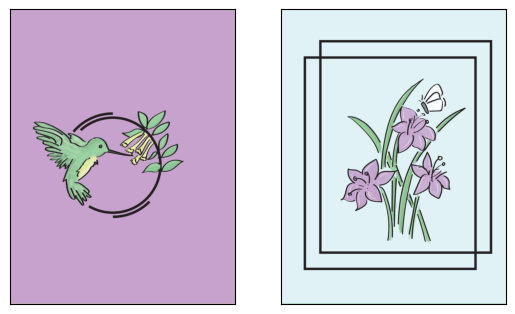

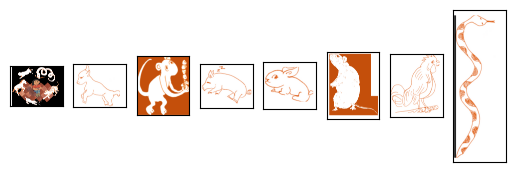

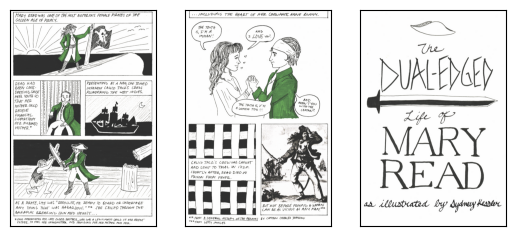

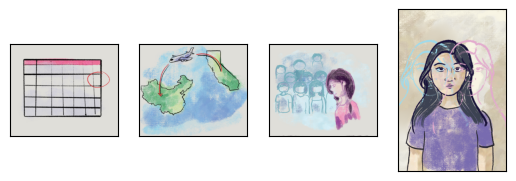

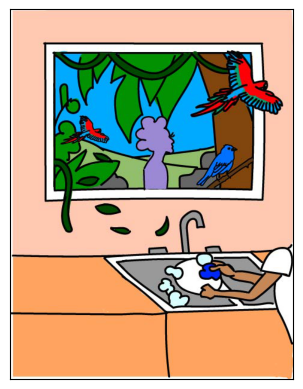

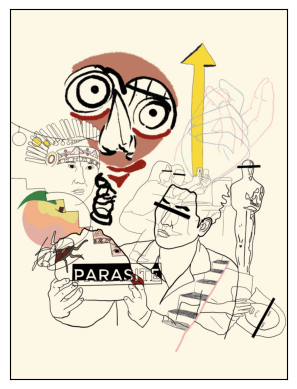

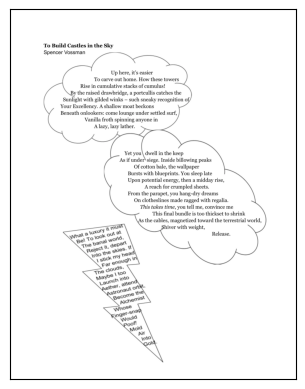

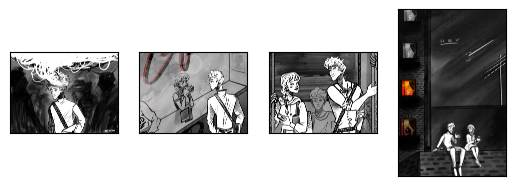

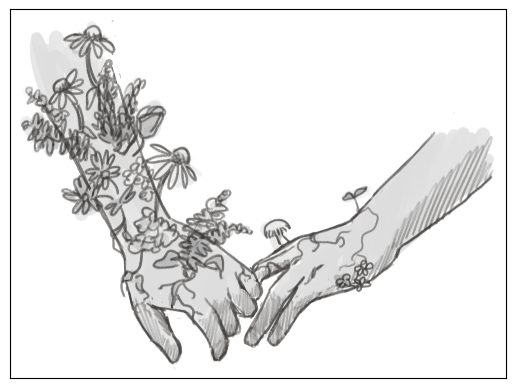

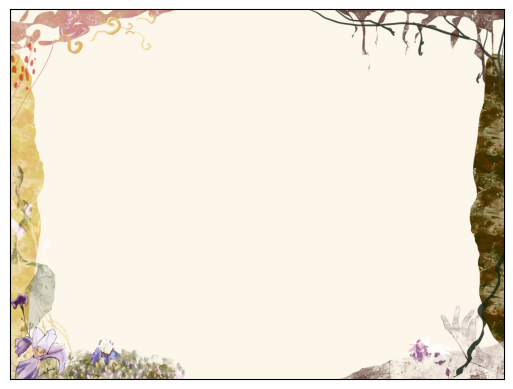

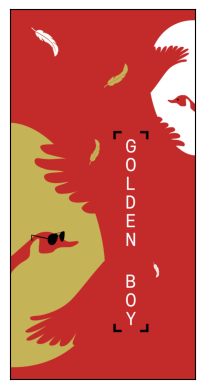

In [60]:
displayRecImgs(test_input, recommend)

## Combining the Artwork Model with Literature Model



Now we would like to figure out how to combine the visual arts recommendation with the literary recommendations. At this point, we have already defined recommendation models for literature and visual arts independent of each other. We have also built cosine matrices that have the same shape as the number of posts on the website.

One approach is to keep the literature and visual models separate from each other and run the visual arts recommendations on pages tagged with "Visual Arts". This has the benefit of not integrating the two systems together which may cause inaccurate predictions over everything if done improperly. However, this approach fails to diversify the user's recommendations as this will lead to visual arts pages recommended to other visual arts pages or literature while prose (fiction, nonfiction, poetry) pages will continue to be recommended to other prose pages with little to no consideration for visual arts pages.

---

A better approach utilizes what is similar about the content-based recommender and visual similarity recommender: **the cosine similarity**. We have proved this is possible before in the content-based recommender by combining the metadata feature vector with the content TF-IDF feature vector. The images had their features extracted to a 4096 vector space, so we can extend the content-based feature vector with this. 

This should theoretically allow any literary arts page to recommend other literary arts page with nonzero similarities between each of them and thus give each post a chance to recommend another. Therefore, visual arts works could be recommended on prose pages that already have images. It is expected that this situation has a low chance of occurring since the TF-IDF vector probably has a strong affinity for other works with text instead of a webpage with no text.  

In [61]:
# Test Suite for expected recommendations based on obvious relevancies
def test_system(cosine_sim):
    test_A = recommender_system('/3/blame-and-balm', cosine_sim,
                                   k=10, showSim=False, sigFigs=5) 
    test_B = recommender_system('/2/when-the-partys-over-interview', cosine_sim,
                                   k=10, showSim=False, sigFigs=5)
    test_C = recommender_system('/5/cognates', cosine_sim,
                                   k=10, showSim=False, sigFigs=5)
    test_D = recommender_system('/2023/missed-connections', cosine_sim,
                                   k=10, showSim=False, sigFigs=5)
    
    print('Test A\n  /3/blame-and-balm | Expect: /3/blame-and-balm-interview')
    print(test_A)
    print('Success!' if '/3/blame-and-balm-interview' in test_A else 'FAILED') 
    
    print('\nTest B\n  /2/when-the-partys-over-interview | Expect: /2/when-the-partys-over')
    print(test_B)
    print('Success!' if '/2/when-the-partys-over' in test_B else 'FAILED') 
    
    print('\nTest C\n  /5/cognates | Expect: para-mi-hermane (Spanish)')
    print(test_C)
    print('Success!' if '/4/para-mi-hermane' in test_C else 'FAILED')
    
    print('\nTest D\n /2023/missed-connections | Expect: /6/you-have-created-an-imaginary-friend')
    print(test_D)
    print('Success!' if '/6/you-have-created-an-imaginary-friend' in test_D else 'FAILED')


### Combination 1: Visual Features and (Meta-TF-IDF)

In [62]:
print(clusterFeatsByPost.shape)
print(meta_tfidf_matrix.shape)

(148, 4096)
(148, 103094)


In [63]:
# clusterFeatsByPost is a scipy sparse matrix, so
# concatenating the feature vectors requires a scipy concatenation function
from scipy.sparse import hstack

litart_matrix = hstack((clusterFeatsByPost, meta_tfidf_matrix))

cosine_sim_litart_1 = cosine_similarity(litart_matrix, litart_matrix)
cosine_sim_litart_1.shape

(148, 148)

In [64]:
recs_litart = {}
for slug in listRes:
    recommendations = recommender_system(slug, cosine_sim_litart_1,
                                         k=10, showSim=False, sigFigs=4)
    recs_litart[slug] = recommendations

In [65]:
direct_recs_litart = test_rec_diversity(recs_litart, showConnections=False)
direct_counts_litart = {}
for k,v in direct_recs_litart:
    direct_counts_litart[v] = direct_counts_litart.get(v, 0) + 1
print('(k, num) posts with direct recommendations:', direct_counts_litart)
direct_recs_litart[-10:]

(k, num) posts with direct recommendations: {0: 38, 1: 20, 2: 14, 3: 14, 4: 8, 5: 13, 6: 3, 7: 4, 8: 4, 9: 3, 10: 3, 11: 3, 12: 2, 13: 4, 15: 5, 16: 1, 18: 1, 20: 1, 22: 1, 30: 1, 32: 2, 34: 1, 35: 1, 38: 1}


[('/2023/to-build-castles-in-the-sky', 16),
 ('/2023/overpriced', 18),
 ('/2023/always-the-victim', 20),
 ('/2023/a-sculpture-from-scratch', 22),
 ('/5/lament-for-the-old-man', 30),
 ('/2023/nesting-dolls-and-snakeskin', 32),
 ('/2023/outdated', 32),
 ('/3/the-middle-of-all-middles', 34),
 ('/5/the-twelve-zodiac-animals-visit', 35),
 ('/2023/homewrecker', 38)]

There are less posts that do not get any direct recommendations in this combining method than the three recommendation systems we have built so far. However, we can do better than this. If you modify the above code block to show the recommendation graph's connected components, there are narrower groupings with the largest group being around 84 and the smallest around 35.

In [66]:
test_system(cosine_sim_litart_1)

Test A
  /3/blame-and-balm | Expect: /3/blame-and-balm-interview
['/1/skin-vilar', '/2020/rain-on-the-rooftops', '/1/at-the-sink', '/3/the-middle-of-all-middles', '/1/the-dual-edged-life-of-mary-read', '/2/little-doll', '/2020/parasite', '/2/may-flowers', '/4/in-a-haze', '/1/untitled']
FAILED

Test B
  /2/when-the-partys-over-interview | Expect: /2/when-the-partys-over
['/2022/thats-so-valid', '/3/blame-and-balm-interview', '/2021/requiem', '/2022/validation', '/2023/homewrecker', '/5/lament-for-the-old-man', '/2023/a-sculpture-from-scratch', '/2023/outdated', '/2021/manifest', '/4/worm']
FAILED

Test C
  /5/cognates | Expect: para-mi-hermane (Spanish)
['/3/the-middle-of-all-middles', '/5/the-twelve-zodiac-animals-visit', '/5/to-you-a-reply', '/5/you-grew-on-me', '/2/little-doll', '/2/underdog', '/2020/rain-on-the-rooftops', '/4/retreat', '/4/in-a-haze', '/2022/west-coast-elegies']
FAILED

Test D
 /2023/missed-connections | Expect: /6/you-have-created-an-imaginary-friend
['/2023/homewr

All of the tests failed, so there is something wrong with this method. If we look closely and compare the literary features to the visual features, we will notice a difference in number ranges.

In [67]:
print(np.min(clusterFeatsByPost), np.max(clusterFeatsByPost), np.mean(clusterFeatsByPost))
print(np.min(tfidf_matrix), np.max(tfidf_matrix), np.mean(tfidf_matrix))

0.0 16.24488067626953 0.3267293222098781
0.0 0.7255359357857215 0.0002831744287036499


### Combination 2: Normalized Visual Features and (Meta-TF-IDF)
It is possible that the data is being skewed significantly because of the difference in not only magnitudes but also averages. Let's try to normalize these extracted features.

In [68]:
from sklearn.preprocessing import normalize
norm_visual = normalize(clusterFeatsByPost)
norm_tfidf = normalize(tfidf_matrix)

In [69]:
litart_matrix_2 = hstack((norm_visual, norm_tfidf))

cosine_sim_litart_2 = cosine_similarity(litart_matrix_2, litart_matrix_2)
cosine_sim_litart_2.shape

(148, 148)

In [70]:
recs_litart_2 = {}
for slug in listRes:
    recommendations = recommender_system(slug, cosine_sim_litart_2,
                                         k=10, showSim=False, sigFigs=4)
    recs_litart_2[slug] = recommendations

In [71]:
direct_recs_litart_2 = test_rec_diversity(recs_litart_2, showConnections=False)
direct_counts_litart_2 = {}
for k,v in direct_recs_litart_2:
    direct_counts_litart_2[v] = direct_counts_litart_2.get(v, 0) + 1
print('(k, num) posts with direct recommendations:', direct_counts_litart_2)
direct_recs_litart_2[-10:]

(k, num) posts with direct recommendations: {0: 50, 1: 24, 2: 11, 3: 12, 4: 5, 5: 6, 6: 4, 7: 2, 8: 1, 9: 3, 10: 4, 11: 3, 12: 5, 14: 1, 15: 1, 16: 1, 17: 2, 18: 3, 21: 1, 23: 2, 25: 1, 27: 1, 28: 2, 31: 1, 36: 1, 37: 1}


[('/5/the-twelve-zodiac-animals-visit', 21),
 ('/5/lament-for-the-old-man', 23),
 ('/3/the-middle-of-all-middles', 23),
 ('/4/love-blooms', 25),
 ('/2023/outdated', 27),
 ('/2023/nesting-dolls-and-snakeskin', 28),
 ('/5/porcelain-in-silks', 28),
 ('/5/invitation', 31),
 ('/4/in-a-haze', 36),
 ('/2023/homewrecker', 37)]

In [72]:
test_system(cosine_sim_litart_2)

Test A
  /3/blame-and-balm | Expect: /3/blame-and-balm-interview
['/1/the-dual-edged-life-of-mary-read', '/4/in-a-haze', '/1/untitled', '/1/treasure', '/1/skin-vilar', '/2020/rain-on-the-rooftops', '/5/porcelain-in-silks', '/4/eclectic-romantic', '/3/the-middle-of-all-middles', '/1/at-the-sink']
FAILED

Test B
  /2/when-the-partys-over-interview | Expect: /2/when-the-partys-over
['/2022/thats-so-valid', '/2021/requiem', '/3/blame-and-balm-interview', '/2/when-the-partys-over', '/2022/validation', '/2023/homewrecker', '/5/lament-for-the-old-man', '/2021/manifest', '/2023/outdated', '/2023/a-sculpture-from-scratch']
Success!

Test C
  /5/cognates | Expect: para-mi-hermane (Spanish)
['/2/underdog', '/4/in-a-haze', '/1/dissonance', '/3/the-divine-diablo-dichotomy', '/4/eclectic-romantic', '/1/the-dual-edged-life-of-mary-read', '/4/wet-t-issues', '/3/the-middle-of-all-middles', '/5/the-temporariness-of-twenty', '/5/the-twelve-zodiac-animals-visit']
FAILED

Test D
 /2023/missed-connections |

### Combination 3: Mean Cosine Visual and (Meta-TF-IDF)

In [73]:
cosine_sim_litart_3 = np.mean(np.array([cosine_sim_meta_tfidf, cosine_sim_art]), axis=0)
cosine_sim_litart_3

array([[0.5       , 0.02051022, 0.00903303, ..., 0.00889781, 0.00864913,
        0.00413398],
       [0.02051022, 0.5       , 0.00547128, ..., 0.00375249, 0.00672675,
        0.00221688],
       [0.00903303, 0.00547128, 0.5       , ..., 0.00490627, 0.00105102,
        0.00181298],
       ...,
       [0.00889781, 0.00375249, 0.00490627, ..., 1.        , 0.14051752,
        0.22991886],
       [0.00864913, 0.00672675, 0.00105102, ..., 0.14051752, 1.        ,
        0.14537836],
       [0.00413398, 0.00221688, 0.00181298, ..., 0.22991886, 0.14537836,
        1.        ]])

In [74]:
recs_litart_3 = {}
for slug in listRes:
    recommendations = recommender_system(slug, cosine_sim_litart_3,
                                         k=10, showSim=False, sigFigs=4)
    recs_litart_3[slug] = recommendations

In [75]:
direct_recs_litart_3 = test_rec_diversity(recs_litart_3, showConnections=False)
direct_counts_litart_3 = {}
for k,v in direct_recs_litart_3:
    direct_counts_litart_3[v] = direct_counts_litart_3.get(v, 0) + 1
print('(k, num) posts with direct recommendations:', direct_counts_litart_3)
direct_recs_litart_3[-10:]

(k, num) posts with direct recommendations: {0: 39, 1: 24, 2: 8, 3: 12, 4: 7, 5: 11, 6: 9, 7: 5, 8: 5, 9: 4, 10: 8, 11: 2, 13: 1, 14: 1, 16: 1, 17: 1, 18: 4, 21: 2, 22: 1, 28: 1, 29: 1, 33: 1}


[('/2023/nesting-dolls-and-snakeskin', 18),
 ('/2/may-flowers', 18),
 ('/2023/outdated', 18),
 ('/4/in-a-haze', 18),
 ('/4/mirror-shards', 21),
 ('/3/sing', 21),
 ('/5/lament-for-the-old-man', 22),
 ('/5/the-twelve-zodiac-animals-visit', 28),
 ('/3/the-middle-of-all-middles', 29),
 ('/2023/homewrecker', 33)]

In [76]:
test_system(cosine_sim_litart_3)

Test A
  /3/blame-and-balm | Expect: /3/blame-and-balm-interview
['/1/skin-vilar', '/2020/rain-on-the-rooftops', '/1/at-the-sink', '/3/the-middle-of-all-middles', '/2/little-doll', '/1/the-dual-edged-life-of-mary-read', '/2/may-flowers', '/2020/parasite', '/4/in-a-haze', '/5/the-twelve-zodiac-animals-visit']
FAILED

Test B
  /2/when-the-partys-over-interview | Expect: /2/when-the-partys-over
['/2/when-the-partys-over', '/2022/thats-so-valid', '/3/blame-and-balm-interview', '/2021/requiem', '/2022/validation', '/2023/homewrecker', '/5/lament-for-the-old-man', '/2021/sand-is-not-good-for-sunflowers', '/2023/a-sculpture-from-scratch', '/3/the-middle-of-all-middles']
Success!

Test C
  /5/cognates | Expect: para-mi-hermane (Spanish)
['/3/the-middle-of-all-middles', '/5/the-twelve-zodiac-animals-visit', '/5/to-you-a-reply', '/5/you-grew-on-me', '/2020/rain-on-the-rooftops', '/2/little-doll', '/4/retreat', '/2/underdog', '/4/in-a-haze', '/2022/west-coast-elegies']
FAILED

Test D
 /2023/misse

### Combination 4: Mean Cosine Visual + TF-IDF + Metadata Count
Is there a better way to combine the recommendation results together? We have four different feature vectors and four different cosine similarity matrices. We found that the metadata counts had high base similarities on their own while TF-IDF on the content did not contribute to predictions to a impactful degree. Combining metadata with TF-IDF may have had an adverse effect on the final predictions. If the average of the cosine matrices were taken after isolating each part, it would place equal weights on the three similarity matrices. This may lead to visual art recommendations having relevance and interacting with literary works and vice versa.

In [77]:
cosine_sim_count.shape
cosine_sim_tfidf.shape
cosine_sim_meta_tfidf.shape
cosine_sim_art.shape

(148, 148)

In [78]:
cosine_sim_3 = np.mean(np.array([cosine_sim_count, cosine_sim_tfidf, cosine_sim_art]), axis=0)
cosine_sim_3

array([[0.66666667, 0.0196745 , 0.00938556, ..., 0.00896395, 0.00882039,
        0.00446968],
       [0.0196745 , 0.66666667, 0.07367548, ..., 0.06456939, 0.00694719,
        0.06306029],
       [0.00938556, 0.07367548, 0.66666667, ..., 0.0796782 , 0.00117573,
        0.07614893],
       ...,
       [0.00896395, 0.06456939, 0.0796782 , ..., 1.        , 0.0945829 ,
        0.22206902],
       [0.00882039, 0.00694719, 0.00117573, ..., 0.0945829 , 1.        ,
        0.09797347],
       [0.00446968, 0.06306029, 0.07614893, ..., 0.22206902, 0.09797347,
        1.        ]])

In [79]:
recs_3 = {}
for slug in listRes:
    recommendations = recommender_system(slug, cosine_sim_3,
                                         k=10, showSim=False, sigFigs=4)
    recs_3[slug] = recommendations

In [80]:
direct_recs_3 = test_rec_diversity(recs_3, showConnections=False)
direct_counts_3 = {}
for k,v in direct_recs_3:
    direct_counts_3[v] = direct_counts_3.get(v, 0) + 1
print('(k, num) posts with direct recommendations:', direct_counts_3)
direct_recs_3[-10:]

(k, num) posts with direct recommendations: {0: 27, 1: 21, 2: 12, 3: 21, 4: 14, 5: 6, 6: 8, 7: 6, 8: 7, 9: 6, 10: 4, 11: 1, 12: 1, 13: 2, 14: 1, 16: 2, 17: 3, 19: 3, 20: 1, 24: 2}


[('/4/in-a-haze', 16),
 ('/2023/planet', 17),
 ('/2023/overpriced', 17),
 ('/2023/to-build-castles-in-the-sky', 17),
 ('/2023/homewrecker', 19),
 ('/2023/too-easily', 19),
 ('/2023/out-of-use', 19),
 ('/5/the-twelve-zodiac-animals-visit', 20),
 ('/2023/outdated', 24),
 ('/5/to-you-a-reply', 24)]

In [81]:
test_system(cosine_sim_3)

Test A
  /3/blame-and-balm | Expect: /3/blame-and-balm-interview
['/1/skin-vilar', '/1/at-the-sink', '/2/little-doll', '/2/fishbowl-brain', '/3/sing', '/5/cognates', '/2022/west-coast-elegies', '/2023/metamorphoses', '/3/blame-and-balm-interview', '/3/grandfather']
Success!

Test B
  /2/when-the-partys-over-interview | Expect: /2/when-the-partys-over
['/2/when-the-partys-over', '/2022/the-mortal-on-the-crosswalk', '/2/toast-interview', '/3/blame-and-balm-interview', '/3/mother-moon-interview', '/2022/thats-so-valid', '/2021/requiem', '/2/may-flowers', '/2020/daylily', '/1/with-liqour']
Success!

Test C
  /5/cognates | Expect: para-mi-hermane (Spanish)
['/5/to-you-a-reply', '/5/you-grew-on-me', '/1/at-the-sink', '/4/retreat', '/2/little-doll', '/5/yours-truly-you', '/3/say-grace', '/2022/west-coast-elegies', '/5/underneath-the-magnolia', '/2023/to-build-castles-in-the-sky']
FAILED

Test D
 /2023/missed-connections | Expect: /6/you-have-created-an-imaginary-friend
['/2023/soliloquy', '/2

Reviewing these results, less than 20% of all posts do not have a direct recommendation. This is much better than the 33% from any of the other approaches and cosine models. The outstanding tests mostly pass with the exception of Cognates, although this could be human error because one of them is not tagged with their translated language and thus it isn't going to show up as a strong features in the cosine similarity.

In [82]:
# Convert the result to JSON and write to file
with open('recommender-3.json', mode='w', encoding='utf8') as outfile:
    outfile.write(json.dumps(recs_3))

## Closing Remarks

This Notebook has explored the different approaches to recommending literary arts between other works irrespective of user preferences. Literature recommendations rely heavily on content-based similarity models such as weighing the frequency of terms found across all works as well as semantics to figure out how to best fit the content. The metadata also plays a large role here as creatives often make works that are similar in style to each other and thus their other works are usually ranked higher than other works. Our findings have shown that with a small dataset of texts to work with, there are very low similarity values when using the TF-IDF. It would be worth exploring CNNs applied to literature to determine if a more complex, learned approach would fit the predictions better.

Recommending art did require the use of CNNs to extract features from the images. Using a pretrained model over a million images helped to make art similarity have a higher accuracy as well as demonstrating that pretrained models can be modified to pull out features rather than making predictions for image classification. Ample testing and observations supplied positive feedback for the predictions made and thus made the visual similarity model work despite the subjectivity of art.

Combining models together was a process that didn't have clear supporting articles on how to do it properly. However, creating tests and experimenting with the similarity function led to success by inferring from the math and other operations it took to fundamentally recommendation systems. The recommender system for Other People Magazine is a representation of how multiple models can ultimately make profound recommendations that wasn't expected to be so accurate.  

**This notebook has an impact on the Other People Magazine by demonstrating that it is possible to perform data science operations over the organization's resources. The custom-built API can always be modified to optimize the kind of information needed to perform a task and thus serves as a use case for further exploration on what can be computationally done for the arts and humanities.**